# Preparing dataset for time series analysis

First, we need to import required modules and packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

Then, we import the dataset which will be analysed below. The file `Rainfall_data.csv` contains monthly information about specific and relative humidity, temperature and precipitation in Mumbai between 2000-2020.

In [3]:
rainfall_data = pd.read_csv("Rainfall_data.csv")

Let's see the summary of the given dataset.

In [4]:
rainfall_data.head()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000,1,1,8.06,48.25,23.93,0.00
1,2000,2,1,8.73,50.81,25.83,0.11
2,2000,3,1,8.48,42.88,26.68,0.01
3,2000,4,1,13.79,55.69,22.49,0.02
4,2000,5,1,17.40,70.88,19.07,271.14


In [5]:
rainfall_data.describe()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
count,252.000000,252.000000,252.0,252.000000,252.000000,252.000000,252.000000
mean,2010.000000,6.500000,1.0,14.416746,67.259524,16.317262,206.798929
std,6.067351,3.458922,0.0,4.382599,17.307101,6.584842,318.093091
min,2000.000000,1.000000,1.0,5.740000,34.690000,4.730000,0.000000
25%,2005.000000,3.750000,1.0,10.010000,51.845000,10.865000,0.402500
50%,2010.000000,6.500000,1.0,15.200000,66.655000,16.915000,11.495000
75%,2015.000000,9.250000,1.0,18.875000,84.610000,22.115000,353.200000
max,2020.000000,12.000000,1.0,20.570000,92.310000,29.340000,1307.430000


In [6]:
type(rainfall_data)

pandas.core.frame.DataFrame

In [7]:
rainfall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               252 non-null    int64  
 1   Month              252 non-null    int64  
 2   Day                252 non-null    int64  
 3   Specific Humidity  252 non-null    float64
 4   Relative Humidity  252 non-null    float64
 5   Temperature        252 non-null    float64
 6   Precipitation      252 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 13.9 KB


In [8]:
rainfall_data.columns

Index(['Year', 'Month', 'Day', 'Specific Humidity', 'Relative Humidity',
       'Temperature', 'Precipitation'],
      dtype='object')

In [9]:
rainfall_data.shape

(252, 7)

Dates in `rainfall_data` are devided into three columns. Merging them all into one makes next steps more comfortable.

In [10]:
rainfall_data["Date"] = pd.to_datetime(rainfall_data[["Year", "Month", "Day"]])
rainfall_data.set_index("Date", inplace=True)
rainfall_data = rainfall_data.drop(columns=["Year", "Month", "Day"])

Let's see how the dataset looks on the plots.

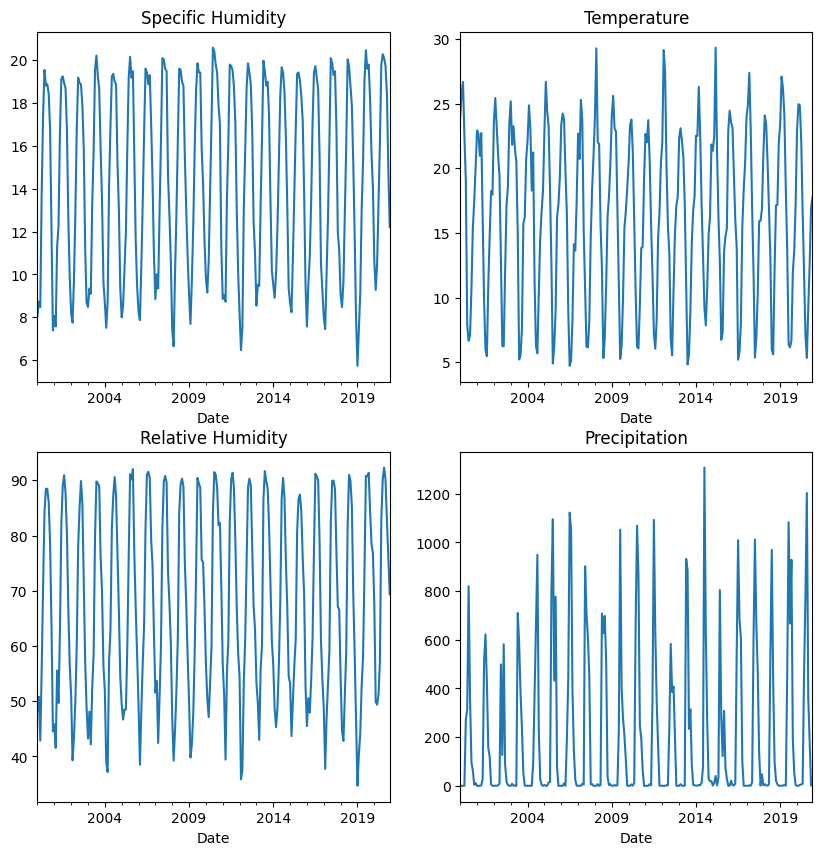

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

rainfall_data["Specific Humidity"].plot(ax=axes[0, 0], title="Specific Humidity")
rainfall_data["Relative Humidity"].plot(ax=axes[1, 0], title="Relative Humidity")
rainfall_data["Temperature"].plot(ax=axes[0, 1], title="Temperature")
rainfall_data["Precipitation"].plot(ax=axes[1,1], title="Precipitation")

plt.show()

Focusing on the fourth plot, we will decompose this time series using additive method and the `seasonal_decompose` function.

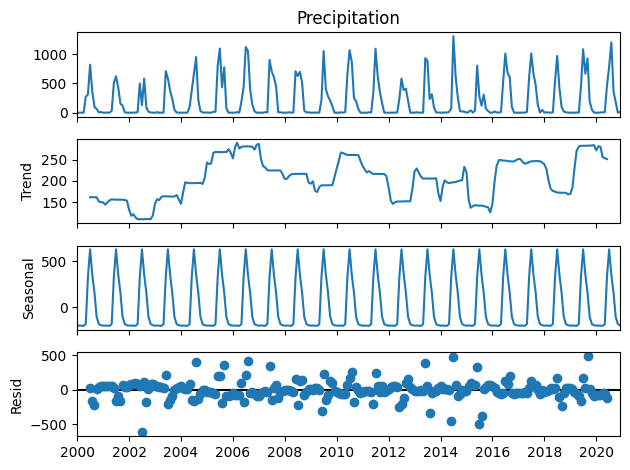

In [12]:
Mumbai = rainfall_data["Precipitation"]
Mumbai.index.freq = 'MS'

seasonal_decompose(Mumbai, model = "additive").plot()
plt.show()

The trend looks irregular and the seasonality is clearly visible.

# Choosing SARIMA model parameters

Let's analyse the ACF function for the precipitation time series.

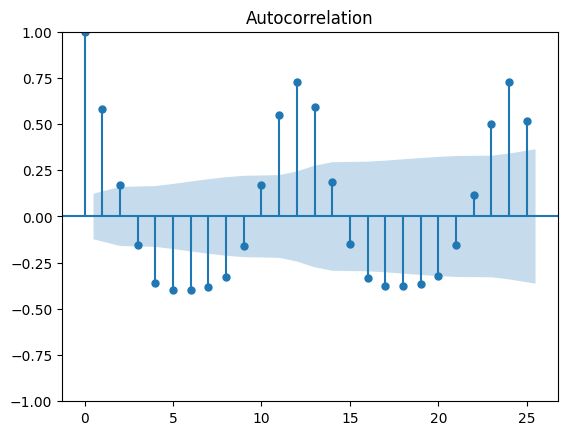

In [13]:
plot_acf(Mumbai)
plt.show()

There are strong peaks at lags 12, 24, etc. which reflect the series’ periodicity. 

Now, we want to eliminate trend and seasonal component. Therefore, we differentiate the original precipitation time series with lags 1, 12 and both to see which of these tranformations will give us the best results.

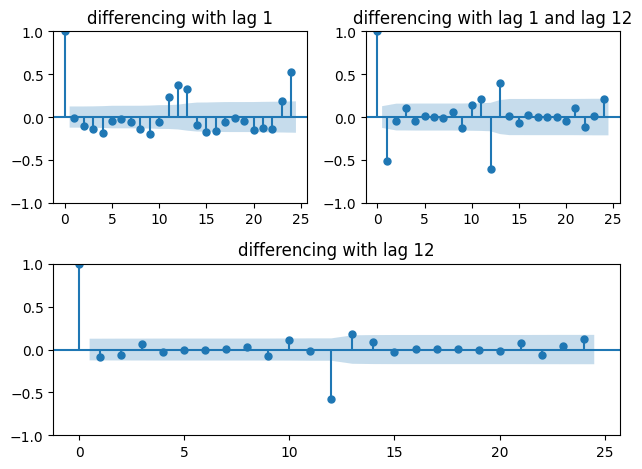

In [14]:
diff_Mumbai = Mumbai.diff().dropna()
diff12_diff_Mumbai = diff_Mumbai.diff(12).dropna()
diff12_Mumbai = Mumbai.diff(12).dropna()

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0), colspan=2)

plot_acf(diff_Mumbai, ax=ax1, title = "differencing with lag 1")
plot_acf(diff12_diff_Mumbai, ax=ax2, title = "differencing with lag 1 and lag 12")
plot_acf(diff12_Mumbai, ax=ax3, title = "differencing with lag 12")

plt.tight_layout()
plt.show()

The last transformation which was differencing by single seasonal lag, gave us the best looking ACF function. We can set the differencing parameters in `SARIMA(p, d, q)(P, D, Q)[12]` to `d = 0` and `D = 1`.

Having the differentiation parameters, we can look at the ACF and PACF functions of the differenced time series to think about the other parameters in `SARIMA(p, 0, q)(P, 1, Q)[12]` models.

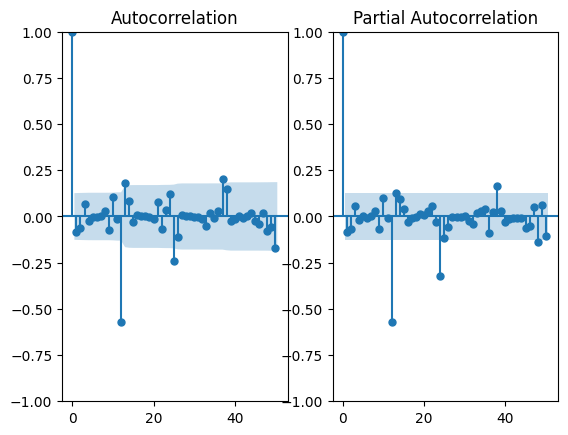

In [15]:
fig, axes = plt.subplots(1, 2)

plot_acf(diff12_Mumbai, lags = 50, ax=axes[0])
plot_pacf(diff12_Mumbai, lags = 50, ax=axes[1])

plt.show()

The values of the ACF function vanish for seasonal lags $|h|>1$. Therefore, we can set the parameter `Q = 1` corresponding to the strong peak at seasonal lag 12. Regarding the PACF function, it also decreases for seasonal lags $|h| > 2$. Considering the risk of model overfitting, we will test the parameter values `P = 1 ` and `P = 2`.

For the non-seasonal lags, no significant peaks are observed. Thus the non-seasonal parameters are set to `p = 0` and `q = 0`. Finally, we can test chosen models which are `SARIMA(0, 0, 0)(1, 1, 1)[12]` and `SARIMA(0, 0, 0)(2, 1, 1)[12]`.

# Testing chosen SARIMA model parameters

First, we will compare `SARIMA(0, 0, 0)(1, 1, 1)[12]` and `SARIMA(0, 0, 0)(2, 1, 1)[12]` using the AICc values of these models.

In [16]:
fit_1 = ARIMA(Mumbai, order = (0,0,0), seasonal_order=(1,1,1,12)).fit()
fit_2 = ARIMA(Mumbai, order = (0,0,0), seasonal_order=(2,1,1,12)).fit()

comparison = pd.DataFrame({
    "AICc" : [fit_1.aicc, fit_2.aicc]
}, index = ["SARIMA(0, 0, 0)(1, 1, 1)[12]", "SARIMA(0, 0, 0)(2, 1, 1)[12]"])

comparison

,AICc
"SARIMA(0, 0, 0)(1, 1, 1)[12]",3123.667834
"SARIMA(0, 0, 0)(2, 1, 1)[12]",3124.738458


It suggests `SARIMA(0, 0, 0)(1, 1, 1)[12]` being more suitable.

Residuals of these models can also tell us a lot. We will test them using the Ljung-Box test, which checks whether the residuals are correlated.

In [17]:

lb1 = acorr_ljungbox(fit_1.resid, lags=[12, 24], return_df=True)
lb2 = acorr_ljungbox(fit_2.resid, lags=[12, 24], return_df=True)

comparison = pd.DataFrame({
    "lag=12": [lb1.loc[12, "lb_pvalue"], lb2.loc[12, "lb_pvalue"]],
    "lag=24": [lb1.loc[24, "lb_pvalue"], lb2.loc[24, "lb_pvalue"]],
}, index = ["SARIMA(0, 0, 0)(1, 1, 1)[12]", "SARIMA(0, 0, 0)(2, 1, 1)[12]"])


comparison

,lag=12,lag=24
"SARIMA(0, 0, 0)(1, 1, 1)[12]",0.409527,0.548034
"SARIMA(0, 0, 0)(2, 1, 1)[12]",0.486796,0.661140


At the 5% significance level, there is no evidence to reject the null hypothesis that the residuals are not autocorrelated.

# Prediction

We divide the rainfall time series into a training set (the first 17 years) and a testing set (the last four years). We then generate 48 rolling forecasts, each with a 12-month forecasting horizon, starting in January 2017.

In [18]:
n = len(Mumbai)
h = 12
p = 48
r = n - (p + h) + 1

train = Mumbai.iloc[:r]
test = Mumbai.iloc[r:]

Then, we prepare bin for values which will be given from the chosen models.

In [19]:
matrix_real = [test.iloc[i:i+12] for i in range(p)]

matrix_a = []
matrix_b = []

In [20]:
for i in range(p):
    
    if i == 0:

        current_train = train

    else:

        current_train = pd.concat([train, test.iloc[:i]])
    
    a = ARIMA(current_train, order = (0,0,0), seasonal_order=(1,1,1,12)).fit()
    b = ARIMA(current_train, order = (0,0,0), seasonal_order=(2,1,1,12)).fit()

    matrix_a.append(a.forecast(steps = h))
    matrix_b.append(b.forecast(steps = h))

matrix_a_values = [x.values for x in matrix_a]
matrix_b_values = [x.values for x in matrix_b]

Having predictions we can plot four examples of how they look like next to the real data. We will show predictions made on january in years 2017-2020.

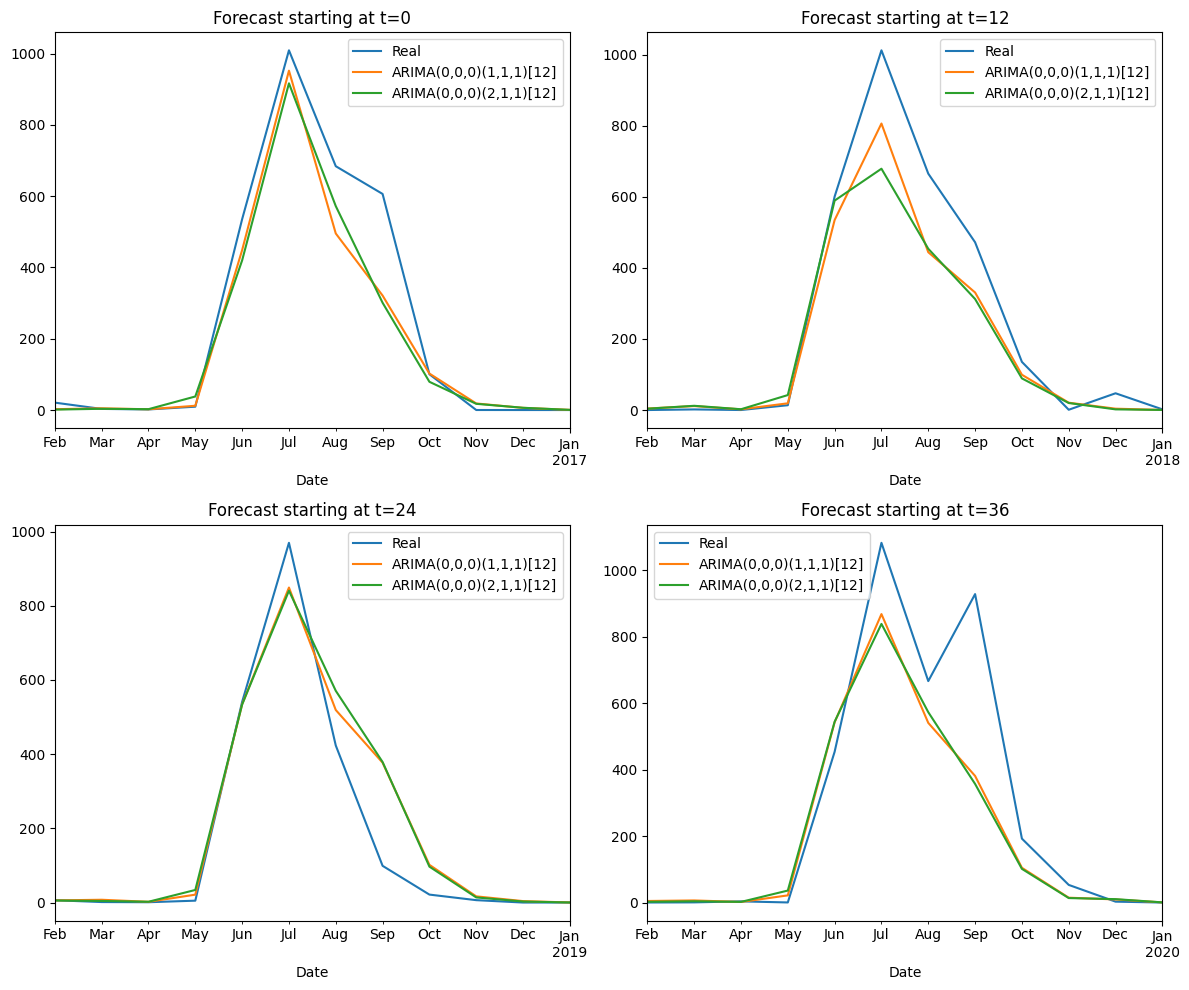

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

I = [0, 12, 24, 36]
positions = [(0,0), (0,1), (1,0), (1,1)]

for i, (r, c) in zip(I, positions):
    
    real_values = matrix_real[i]
    forecast_a = matrix_a[i]
    forecast_b = matrix_b[i]
    
    ax = axes[r, c]
    
    real_values.plot(ax=ax, label="Real")
    pd.Series(forecast_a).plot(ax=ax, label="ARIMA(0,0,0)(1,1,1)[12]")
    pd.Series(forecast_b).plot(ax=ax, label="ARIMA(0,0,0)(2,1,1)[12]")
    
    ax.set_title(f"Forecast starting at t={i}")
    ax.legend()

plt.tight_layout()
plt.show()

The beginnings of wet seasons are well predicted, however the ends do not look as good. 

Now we can compare the results of these predictions using MSE.

In [22]:
np.mean((np.array(matrix_a) - np.array(matrix_real))**2)
np.mean((np.array(matrix_b) - np.array(matrix_real))**2)

np.float64(20985.02036680159)

From all statistics and results we used, the better option seems to be the `ARIMA(0,0,0)(1,1,1)[12]` model. It has lower AICc and MSE value and on the plots of predictions is approximately more suitable than the `ARIMA(0,0,0)(2,1,1)[12]` model.

# The end of wet season

As we already noticed, predictions of the beginning and end of wet season have visibly different quality. We will try to find if there is any other better way to predict when the monsoon ends. In order to do that we will use the binary logistic regression.